## Bioassay experiment 

In the development of drugs and other chemical compounds, acute toxicity tests or bioassay experiments are commonly performed on animals. Such experiments proceed by adminis- tering various dose levels of the compound to batches of animals. The animals’ responses are typically characterized by a dichotomous outcome: for example, alive or dead, tumor or no tumor. An experiment of this kind gives rise to data of the form
$$(x_i,n_i,y_i);\ i = 1,\ldots,k,$$
where $x_i$ represents the $i$th of $k$ dose levels (often measured on a logarithmic scale) given to $n_i$ animals, of which $y_i$ subsequently respond with positive outcome. 
Example from Gelman et al. 2014

In [1]:
import scipy.stats as stats
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
from cmdstanpy import CmdStanModel

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"


plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

import pandas as pd
from scipy.special import expit  # aka logistic


In [2]:

def ribbon_plot(xt, fs, ax=None,zorder=0):
    '''Plot a ribbon plot for regression and similar. 
    Plot consists of quantiles (by 10%) of a variate as a function of covariate.
    '''
    if ax is None:
        ax = plt.gca()
    probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    perc_interv=np.percentile(fs, probs, axis=0)
    ax.fill_between(xt,perc_interv[0,:],perc_interv[8,:],color=light,zorder=zorder)
    ax.fill_between(xt,perc_interv[1,:],perc_interv[7,:],color=light_highlight,zorder=zorder)
    ax.fill_between(xt,perc_interv[2,:],perc_interv[6,:],color=mid,zorder=zorder)
    ax.fill_between(xt,perc_interv[3,:],perc_interv[5,:],color=mid_highlight,zorder=zorder)
    ax.plot(xt,perc_interv[4,:],color=dark,zorder=zorder)
    return(ax)

### Ribbon plot
This is a visual statistic, showing how behave quantiles of a sampled variate as a function of covariate. 
Example:

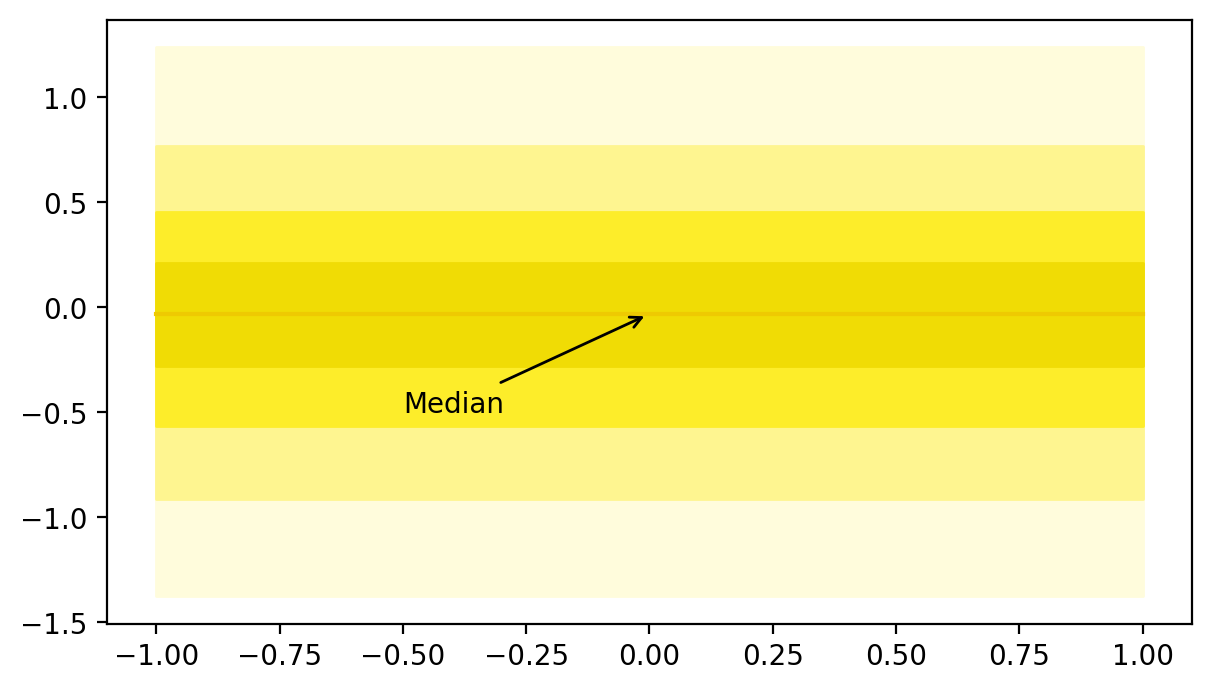

In [3]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
covariate=np.linspace(-1,1)
np.random.seed(4052020)
variate=np.repeat(np.random.normal(size=1000)[:,None],50,axis=1)
axes=ribbon_plot(covariate,variate)
axes.annotate('Median',xy=(0,np.median(variate[:,0])),xytext=(-0.5, -0.5),arrowprops={'arrowstyle':'->'})
plt.show()

In [4]:
print(variate.shape)
print(covariate.shape)

(1000, 50)
(50,)


## Data

An example of real data from such an experiment is shown in below twenty animals were tested, five at each of four dose levels.

In [5]:
# data
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])
pd.DataFrame({'Dose xi':x,'Dose of animals ni':n,'Number of deaths yi':y})

,Dose xi,Dose of animals ni,Number of deaths yi
0,-0.86,5,0
1,-0.30,5,1
2,-0.05,5,3
3,0.73,5,5


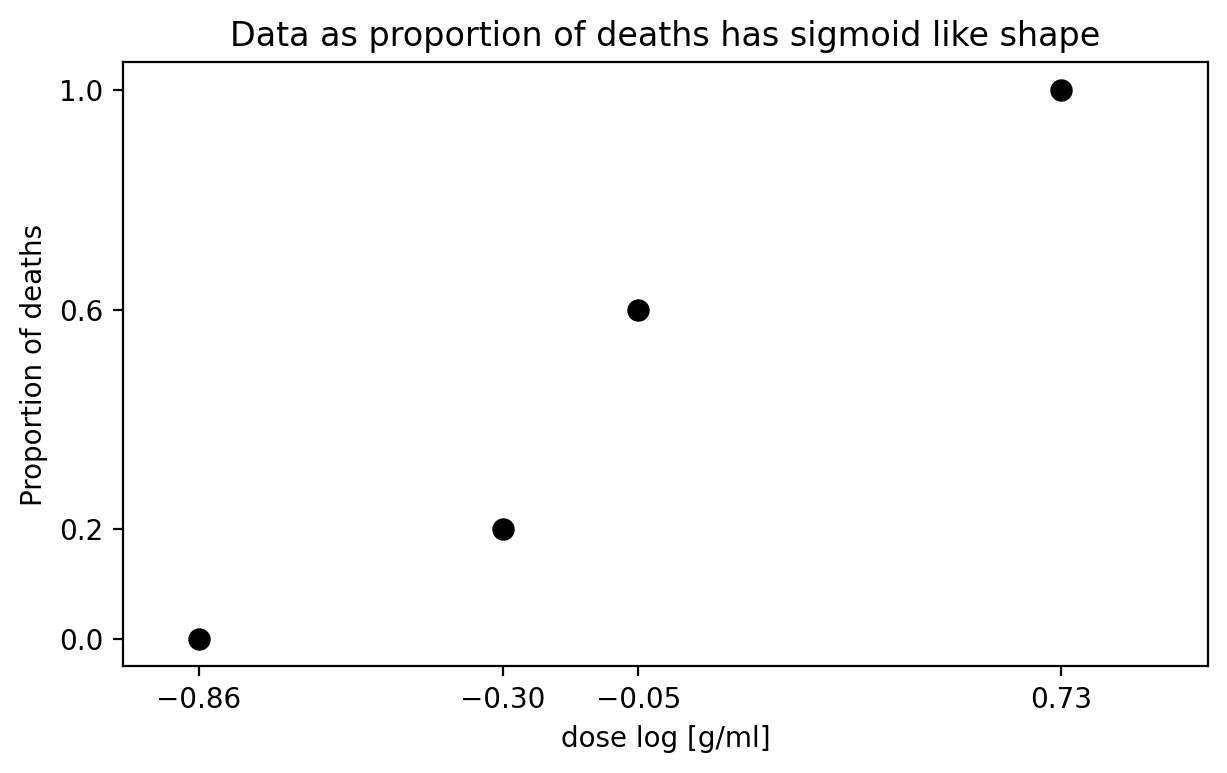

In [6]:
# plot the data
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.scatter(x, y/n, 50, color='black')
axes.set_xlim((-1, 1))
axes.set_xlabel('dose log [g/ml]')
axes.set_ylabel('Proportion of deaths');
axes.set_xticks(x)
axes.set_yticks(y/n)
axes.set_title('Data as proportion of deaths has sigmoid like shape')

plt.show()

## Model
- We can consider outcomes of the five animals within each group $i$ as exchangeable
- it seems reasonable to model them as independent with equal probabilities,
- which implies that the data points $y_i$ are binomially distributed:

$$y_i|\theta_i\sim\mathrm{Binomial}(n_i,\theta_i)$$

### Relationship between dose and probability

- The simplest model of the dose - response relation - that is, the relation of $\theta_i$ to $x_i$ - is linear: $$\theta_i = \alpha + \beta x_i$$
- We need a restriction of probability to (0,1)

$$
\mathrm{logit}(\theta_i)=\alpha+\beta x_i
$$

### Likelihood and posterior
Likelihood for single experiment can be defined as
$$
p(y_i|\alpha,\beta,n_i,x_i)\propto[\mathrm{logit}^{-1}(\alpha+\beta x_i)]^{y_i}[1-\mathrm{logit}^{-1}(\alpha+\beta x_i)]^{n_i-y_i}
$$
And that leads to the posterior
$$
\begin{aligned}
p(\alpha,\beta|y,n,x)\propto {}&p(\alpha,\beta|n,x)p(y_1,\ \ldots,\ y_i|\alpha,\beta,n,x)\\
\propto {}&p(\alpha,\beta)\prod_{i=1}^k p(y_i|\alpha,\beta,n_i,x_i)
\end{aligned}
$$

### Prior for regression coefficients
We are generally uninformed about prior. We however prefer to use weakly informative prior, just to provide some kind of regularization.

Following "[Prior choice recommendation](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)" page at [Stan Wiki](https://github.com/stan-dev/stan/wiki/)

Prior for the regression coefficients in logistic regression (non-sparse case) $$\beta \sim t_\nu(0,s)$$
where $s$ is chosen to provide weak information on the expected scale, and 3<$\nu$<7.

## Prior predictive checks

In [7]:
with open('bioassay_ppc.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of measurements
  int N[M];//count of animals per experiment
  real X[M];//doses of substance per experiment
}


generated quantities {
  real alpha=student_t_rng(5,0,10);
  real beta=student_t_rng(5,0,10);

  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = binomial_rng(N[k],inv_logit(alpha+beta*X[k]));
  }
}



In [8]:
model_ppc=CmdStanModel(stan_file='bioassay_ppc.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpfngisv2k/tmpie89_3bx
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 5 - Multiparameter models/Bioassay/bioassay_ppc


In [9]:
R=1000
data_sim=dict(M=len(x),N=n,X=x)
sim=model_ppc.sample(data=data_sim,
                     fixed_param=True, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     seed=29042020)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [10]:
alpha_sim=sim.stan_variable('alpha')
beta_sim=sim.stan_variable('beta')
y_sim=sim.stan_variable('y_sim')

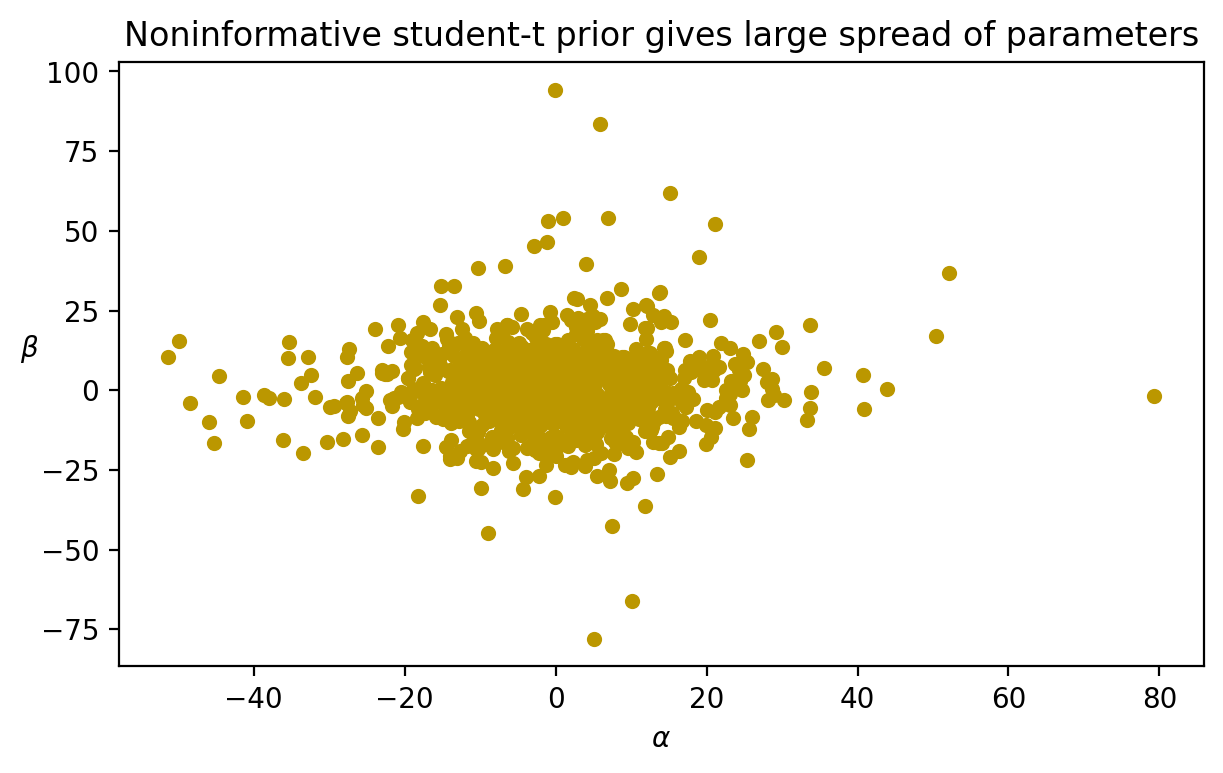

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.scatter(alpha_sim, beta_sim, 20, color=dark_highlight)
axes.set_xlabel(r'$\alpha$')
axes.set_ylabel(r'$\beta$',rotation=0)
axes.set_title('Noninformative student-t prior gives large spread of parameters')
plt.show()

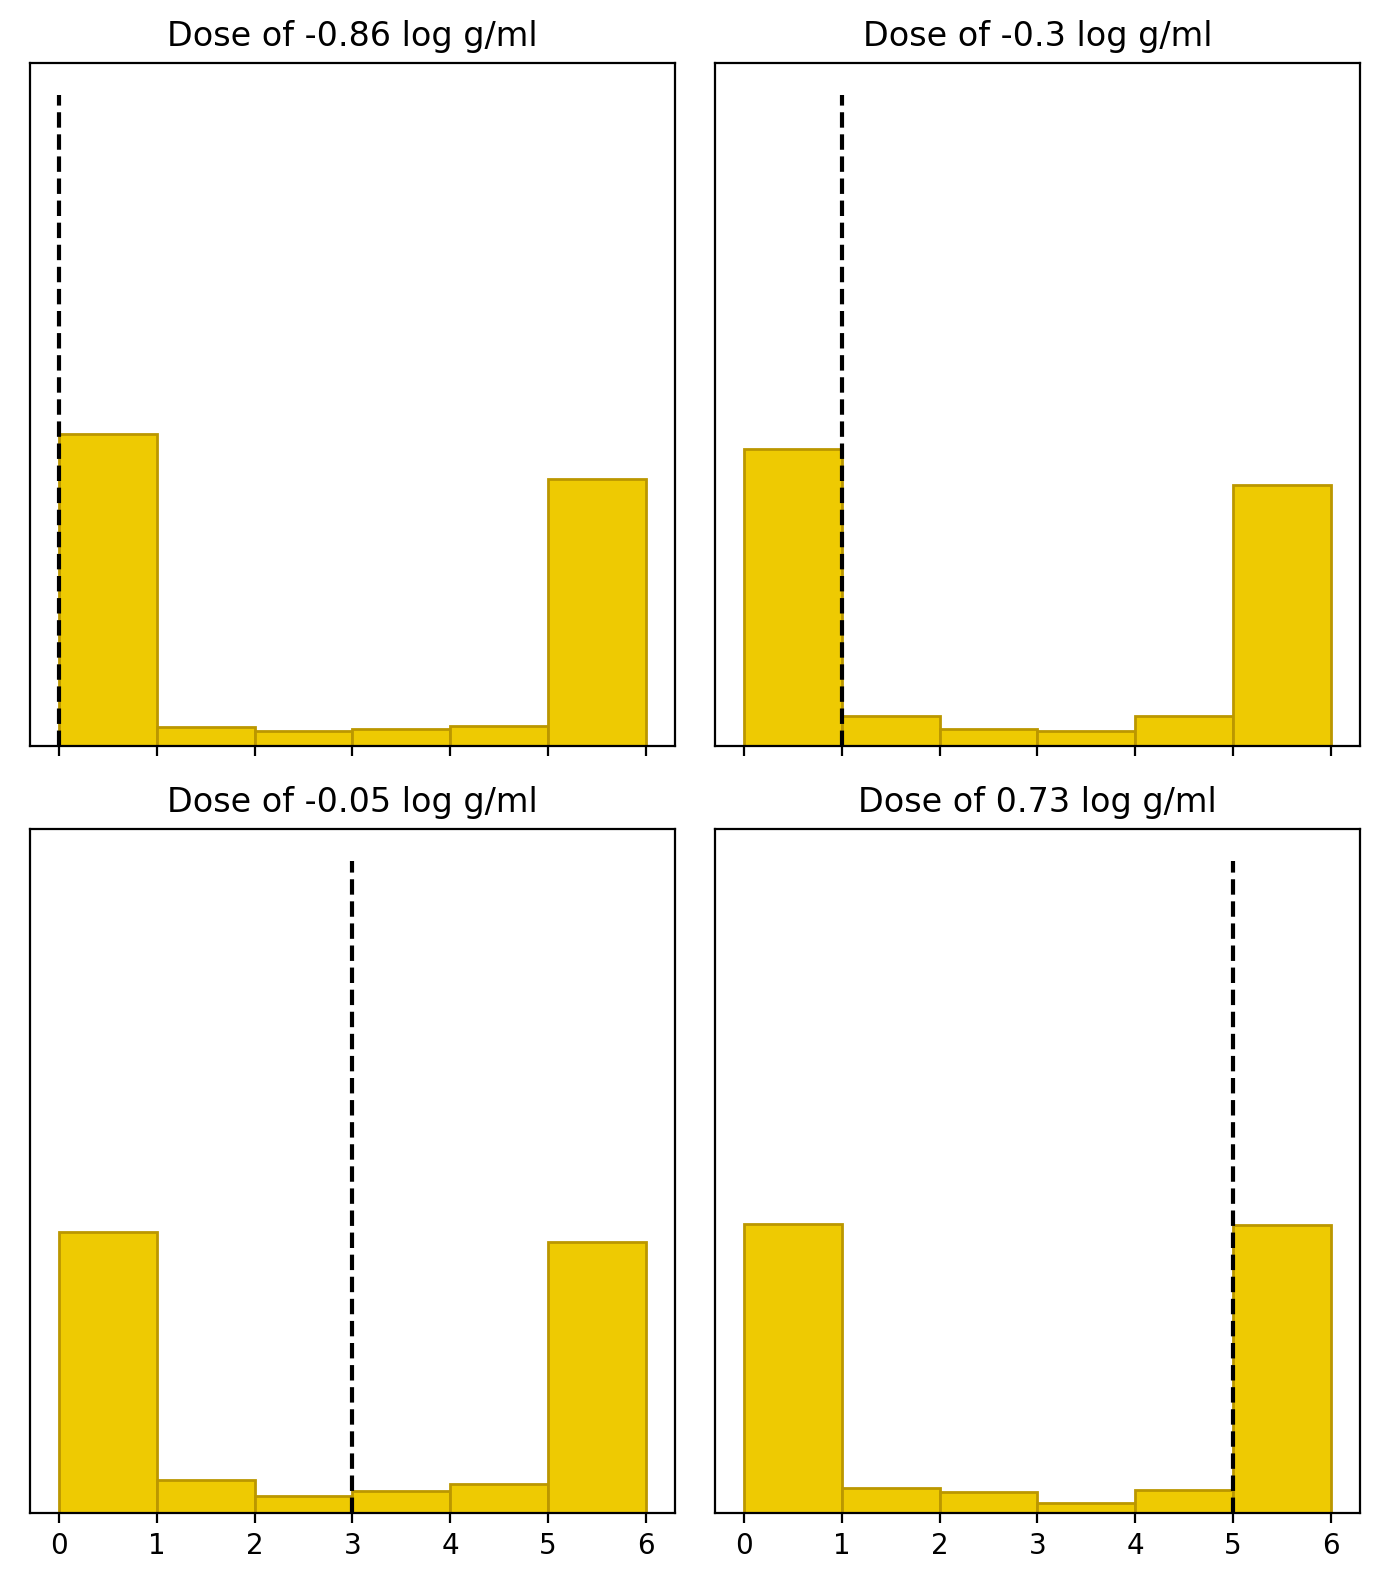

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(7, 8), sharex=True,sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(4):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=[0,1,2,3,4,5,6],color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title('Dose of '+str(x[k])+' log g/ml')
    ax.plot([y[k],y[k]],[0,1],linestyle='--',color='black')
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_yticks([])
fig.tight_layout()

plt.show()

Prior predicted outputs are strongly skewed for one or the other end, but actual measurements are also possible.

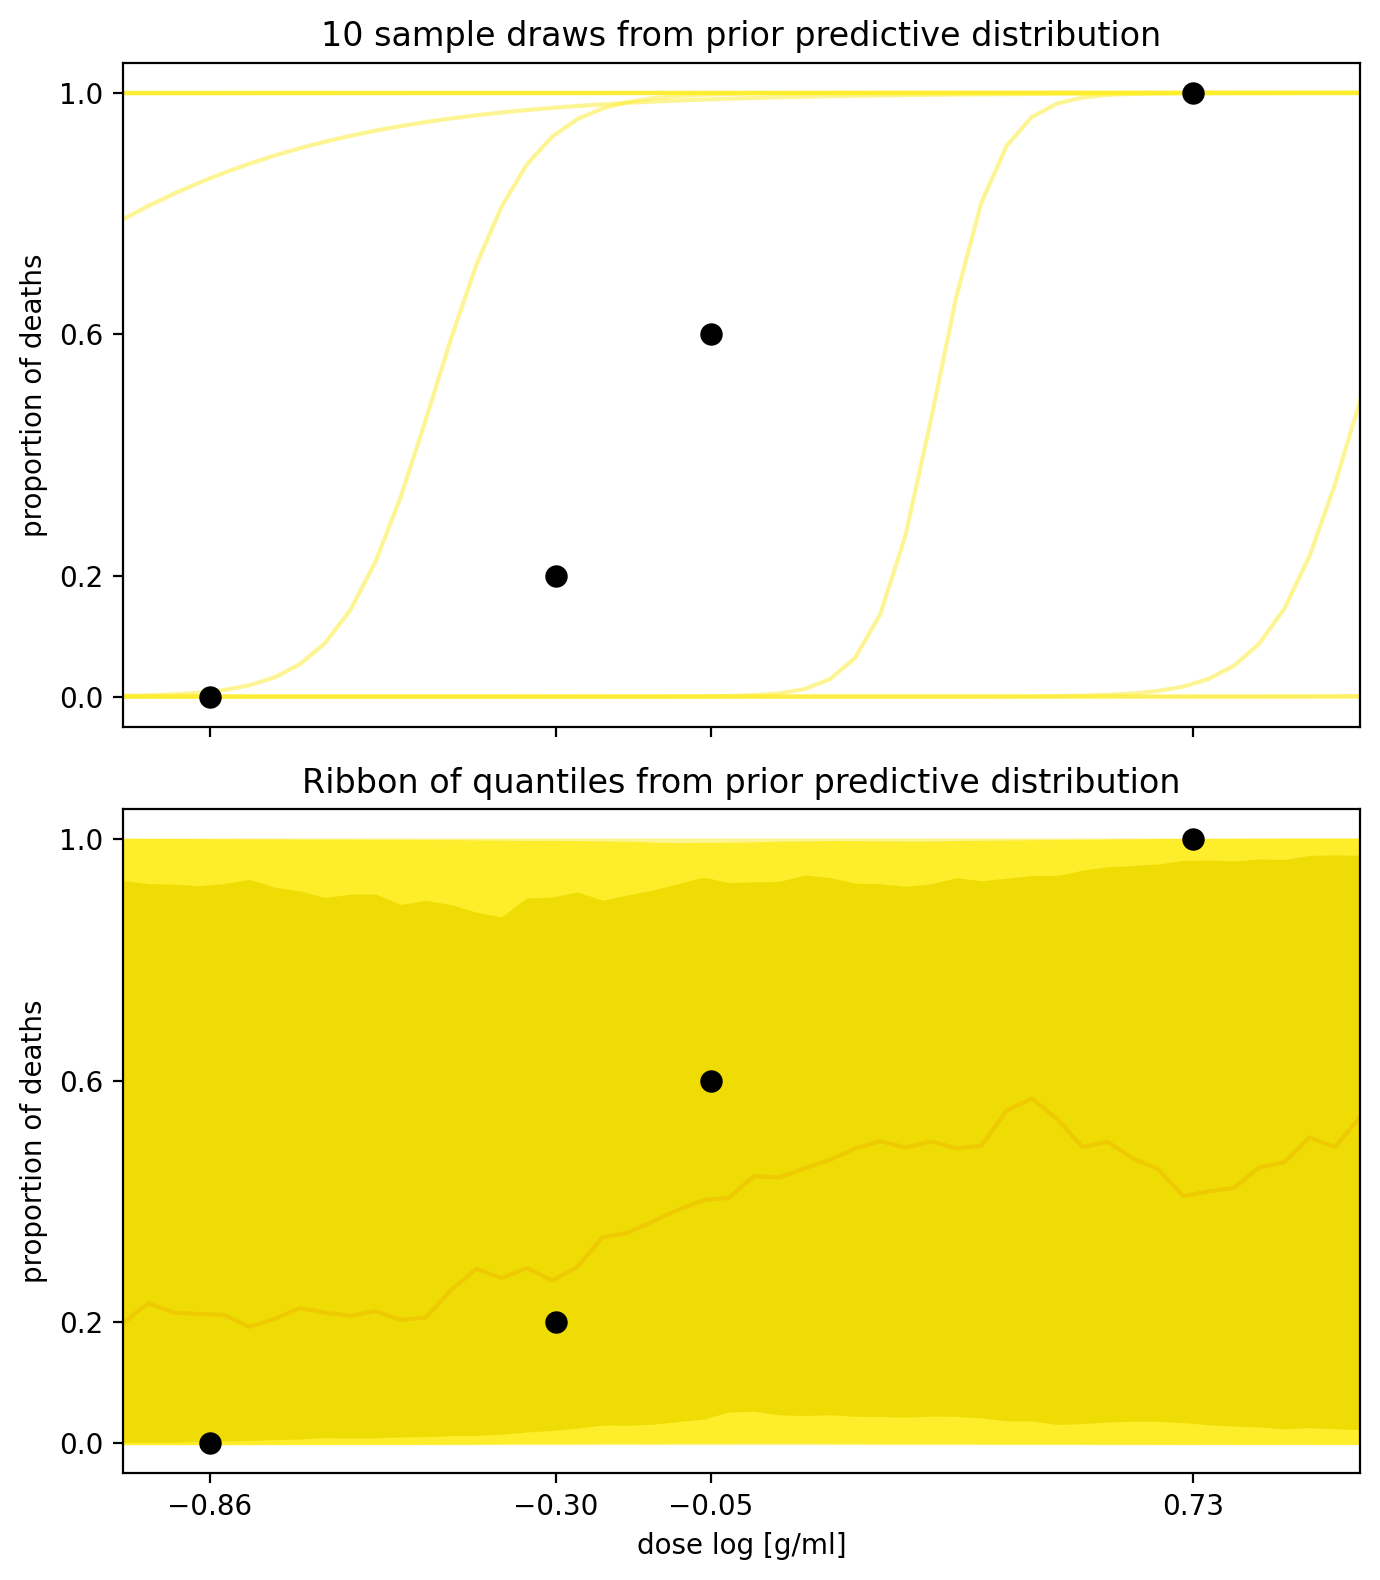

In [13]:

# plot samples with the data
xt = np.linspace(-1, 1)
fs = expit(alpha_sim[:, None] + beta_sim[:, None]*xt)

# ceate figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# plot 10 first samples
ax = axes[0]
ax.plot(xt, fs[:10].T, color=mid, alpha=0.5,zorder=0)
ax.scatter(x, y/n, 50, color='black',zorder=1)
ax.set_xlim((-1, 1))
ax.set_ylabel('proportion of deaths')
ax.set_title('10 sample draws from prior predictive distribution')
ax.set_yticks(y/n)
ax.set_xticks(x)

# plot ribbon of quantiles from 10% to 90%
ax = axes[1]
ax=ribbon_plot(xt,fs,ax)
ax.scatter(x, y/n, 50, color='black')
ax.set_xlim((-1, 1))
ax.set_xlabel('dose log [g/ml]')
ax.set_ylabel('proportion of deaths')
ax.set_title('Ribbon of quantiles from prior predictive distribution')
ax.set_yticks(y/n)
ax.set_xticks(x)

fig.tight_layout()


## Posterior inference

In [14]:
with open('bioassay_fit.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of measurements
  int N[M];//count of animals per experiment
  real X[M];//doses of substance per experiment
  int y[M];//outcomes
}
parameters {
  real alpha;
  real beta;
}

transformed parameters {
  vector[M] theta;
  for (k in 1:M) {
    theta[k] = inv_logit(alpha+beta*X[k]);
  }
}

model {
  target += student_t_lpdf(alpha|5,0,10);
  target += student_t_lpdf(beta|5,0,10);
  for (k in 1:M) {
    target += binomial_lpmf(y[k]|N[k],theta[k]);
  }
}

generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = binomial_rng(N[k],theta[k]);
  }
}



In [15]:
model = CmdStanModel(stan_file='bioassay_fit.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpd_j_edjp/tmpihcz_wg3
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 5 - Multiparameter models/Bioassay/bioassay_fit


In [16]:
data = dict(M = len(x),N = n, X=x,y=y)

In [19]:
fit = model.sample(data=data,seed= 27042020)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [20]:
fit.diagnose()

INFO:cmdstanpy:Processing csv files: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp3gw4y2x9/bioassay_fit-202104252233-1-o1xn46xt.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp3gw4y2x9/bioassay_fit-202104252233-2-fiwuscoa.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp3gw4y2x9/bioassay_fit-202104252233-3-_iets_ii.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp3gw4y2x9/bioassay_fit-202104252233-4-s2mvb93u.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp3gw4y2x9/bioassay_fit-202104252233-1-o1xn46xt.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp3gw4y2x9/bioassay_fit-202104252233-2-fiwuscoa.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp3gw4y2x9/bioassay_fit-202104252233-3-_iets_ii.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp3gw4y2x9/bioassay_fit-202104252233-4-s2mvb93u.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [22]:
alpha=fit.stan_variable('alpha')
beta=fit.stan_variable('beta')

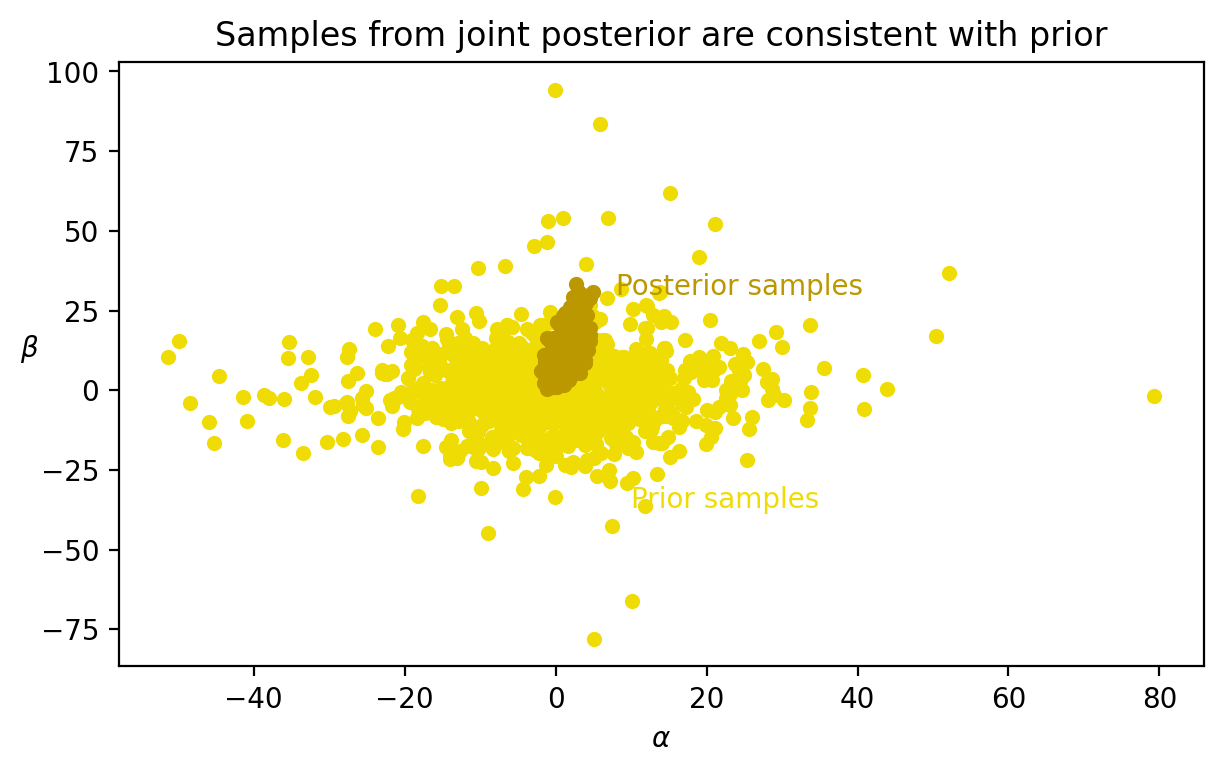

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.scatter(alpha_sim, beta_sim, 20, color=mid_highlight)
axes.scatter(alpha, beta, 20, color=dark_highlight)
axes.set_xlabel(r'$\alpha$')
axes.set_ylabel(r'$\beta$',rotation=0)
axes.set_title('Samples from joint posterior are consistent with prior')
axes.text(8,30,'Posterior samples',color=dark_highlight)
axes.text(10,-37,'Prior samples',color=mid_highlight)

plt.show()

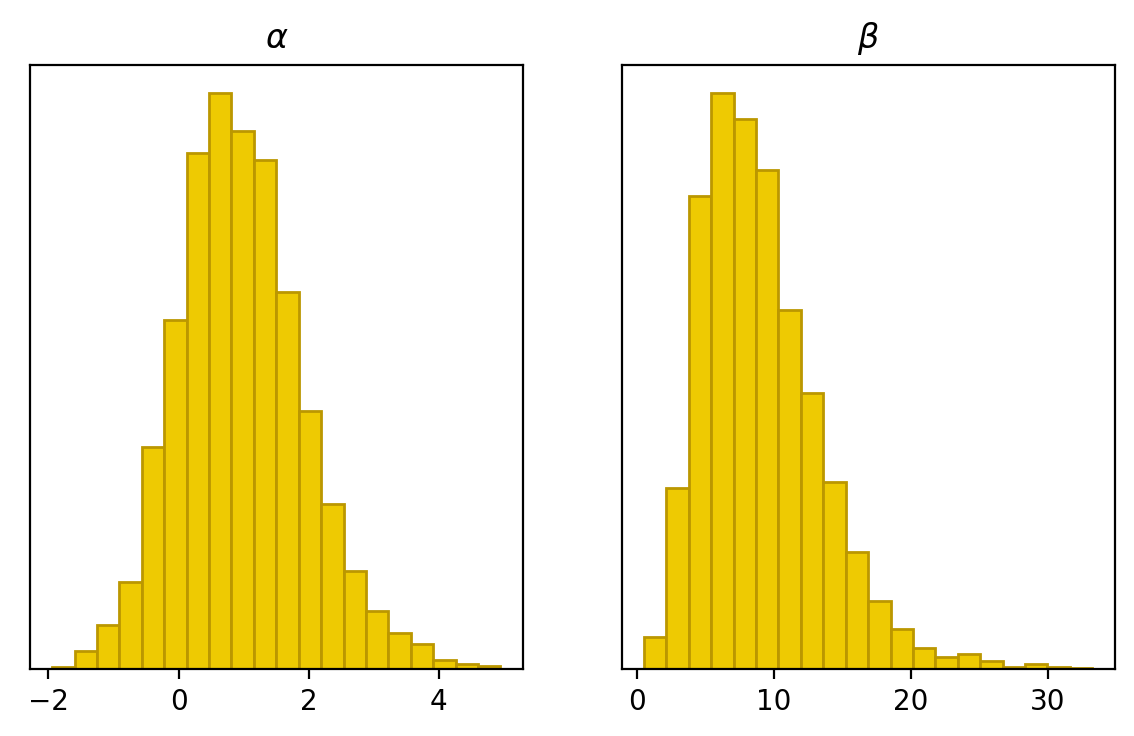

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax=axes[0]
ax.hist(alpha,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax.set_title(r'$\alpha$')
ax.set_yticks(());
ax2=axes[1]
ax2.hist(beta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'$\beta$')
ax2.set_yticks(());
plt.show()

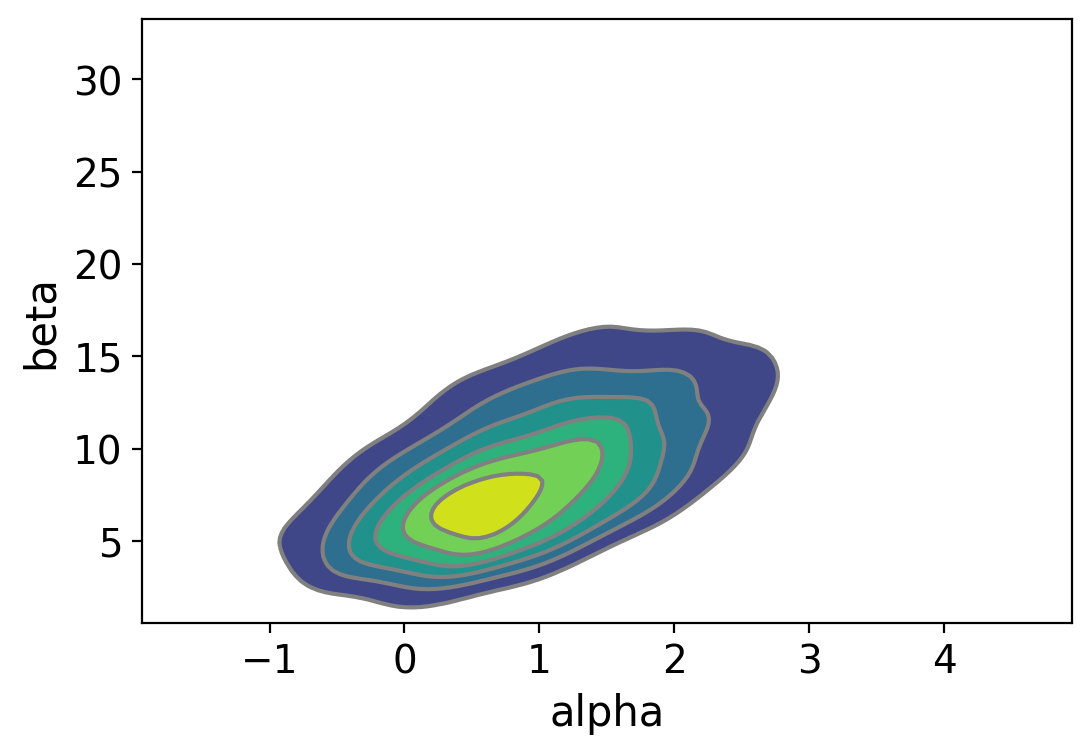

In [26]:
axes=az.plot_pair(fit, var_names=['alpha','beta'],kind='kde')

### Posterior predictive distribution

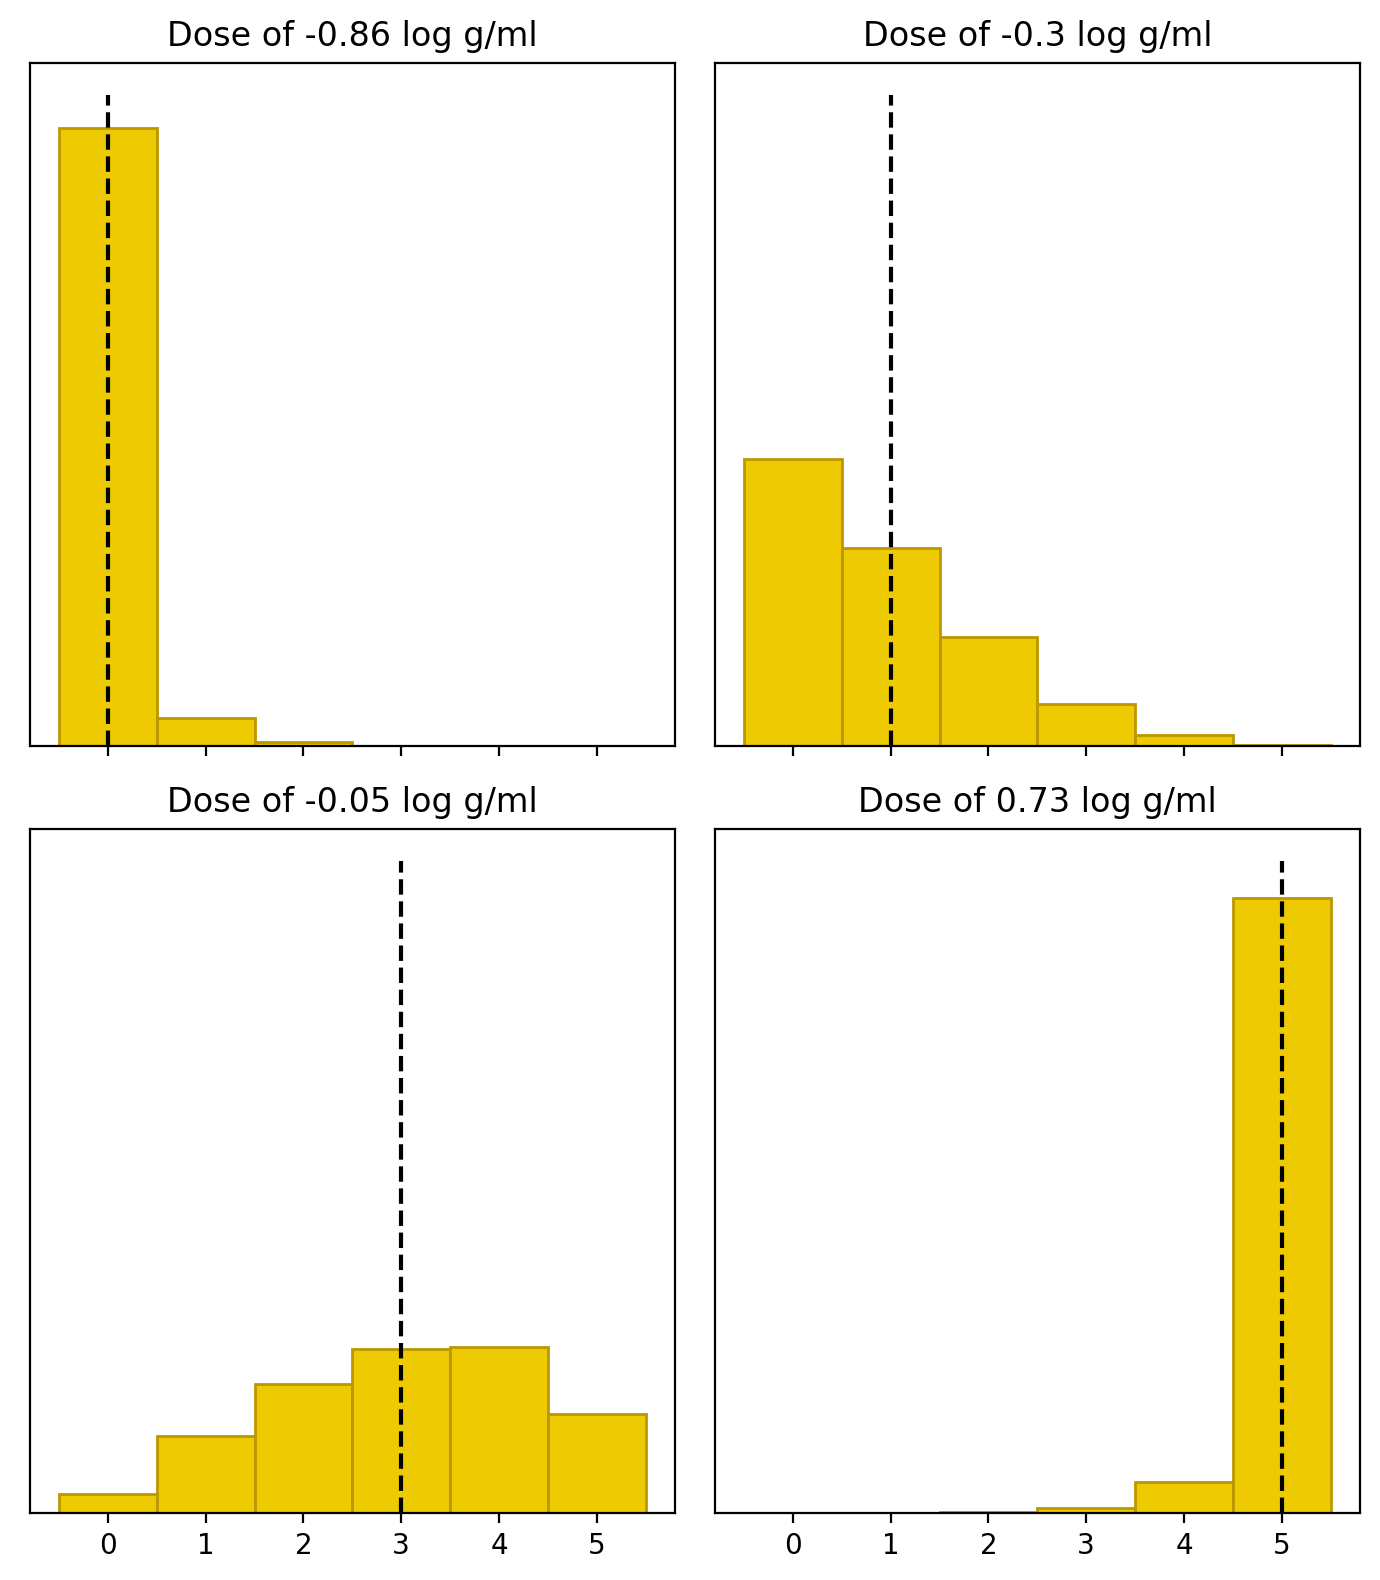

In [31]:
y_sim=fit.stan_variable('y_sim')
fig, axes = plt.subplots(2, 2, figsize=(7, 8), sharex=True,sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(4):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=np.linspace(-0.5,5.5,7),color=dark,edgecolor=dark_highlight,density=True)
    ax.plot([y[k],y[k]],[0,1],linestyle='--',color='black')
    ax.set_title('Dose of '+str(x[k])+' log g/ml')
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_yticks([])
fig.tight_layout()

plt.show()

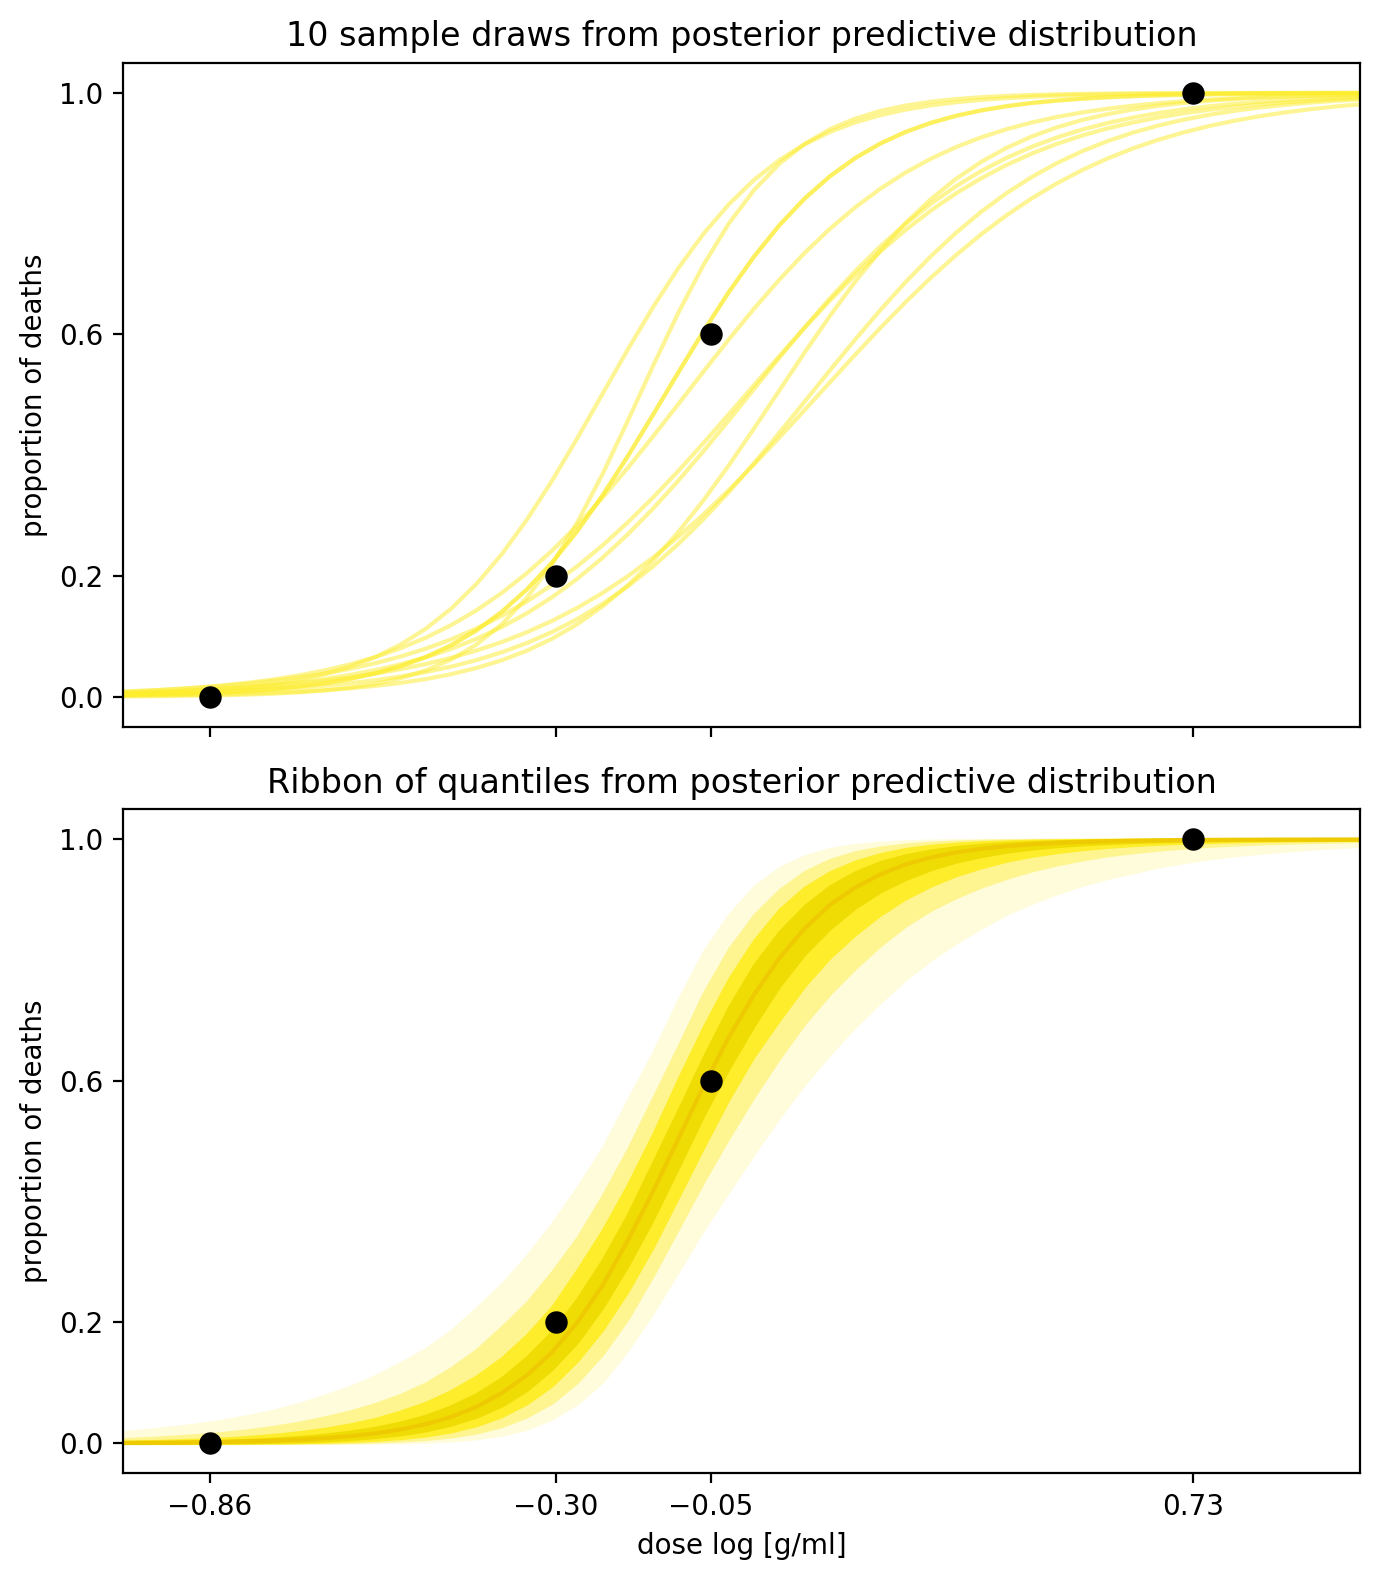

In [32]:
# plot samples with the data
xt = np.linspace(-1, 1)
fs = expit(alpha[:, None] + beta[:, None]*xt)

# ceate figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# plot 10 first samples
ax = axes[0]
ax.plot(xt, fs[:10].T, color=mid, alpha=0.5,zorder=0)
ax.scatter(x, y/n, 50, color='black',zorder=1)
ax.set_xlim((-1, 1))
ax.set_ylabel('proportion of deaths')
ax.set_title('10 sample draws from posterior predictive distribution')
ax.set_yticks(y/n)

# plot ribbon of quantiles from 10% to 90% and median
ax = axes[1]
ax=ribbon_plot(xt,fs,ax)

ax.scatter(x, y/n, 50, color='black',zorder=1)
ax.set_xlim((-1, 1))
ax.set_xlabel('dose log [g/ml]')
ax.set_ylabel('proportion of deaths')
ax.set_title('Ribbon of quantiles from posterior predictive distribution')
ax.set_yticks(y/n)
ax.set_xticks(x)
fig.tight_layout()

## Estimation of LD50
A parameter of common interest in bioassay studies is the LD50 - the dose level at which the probability of death is 50%. In our logistic model, a 50% survival rate means

$$
\mathrm{LD50:}\ \mathrm{E}\left(\frac{y_i}{n_i}\right)=\mathrm{logit}^{-1}(\alpha+\beta x_i)=0.5
$$
This parameter makes sense only for $\beta>0$ as otherwise the increase of the dose reduces death risk.

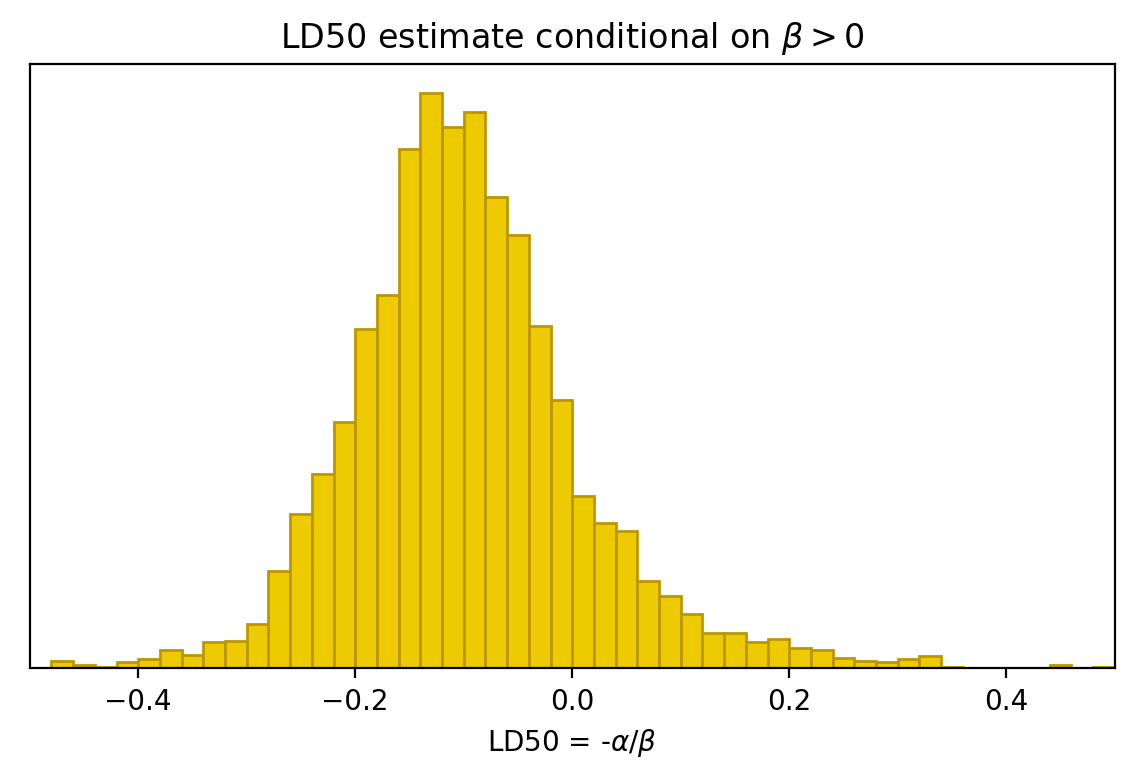

In [34]:
bpi = beta > 0
samp_ld50 = -alpha[bpi]/beta[bpi]
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hist(samp_ld50, np.arange(-0.5, 0.51, 0.02),color=dark,edgecolor=dark_highlight)
axes.set_xlim([-0.5, 0.5])
axes.set_xlabel(r'LD50 = -$\alpha/\beta$')
axes.set_yticks(())
axes.set_title(r'LD50 estimate conditional on $\beta>0$')
plt.show()


In [35]:
print('Median: {:4.2f}'.format(np.median(samp_ld50)))
print('90% confidence interval: ',['{:4.2f}'.format(k) for k in np.percentile(samp_ld50,[5,95],axis=0)])

Median: -0.10
90% confidence interval:  ['-0.25', '0.09']


In our case all samples of $\beta$ were positive, however if that was not the case using mean of $\alpha$ and $\beta$ to compute LD50 would be biased.

In [36]:
10**(-0.25),10**0.08

(0.5623413251903491, 1.202264434617413)

In [37]:
10**(-0.11)

0.7762471166286917

4000